# Training a convolutional neural network with Caffe

We want to train a classifier on the MNIST dataset, which is a publically available dataset of handwritten digits such as the ones below:

![image](./images/mnistdigits.gif)

We will use a very basic convolutional network architecture called LeNet, which looks something like this:

![image](./images/lenet5.png)

Since the network is pretty small and the classification task isn't too demanding, it won't take too long time to train to decent precision from scratch.

In our case we've preloaded the dataset, but it can be loaded with these scripts available in the default caffe installation:

```
data/mnist/get_mnist.sh
examples/mnist/create/mnist.sh
```

In [1]:
caffe_root = '/home/ubuntu/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

from pylab import *
%matplotlib inline

/usr/lib/python2.7/dist-packages/pkg_resources.py:1031: UserWarning: /home/ubuntu/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [2]:
# write out model definition from file
!cat ./models/lenet_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  include {
    phase: TRAIN
  }
  data_param {
    source: "/home/ubuntu/caffe/examples/mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  include {
    phase: TEST
  }
  data_param {
    source: "/home/ubuntu/caffe/examples/mnist/mnist_test_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_outpu

In [6]:
# write out solver parameters from file
!cat ./models/lenet_solver.prototxt

# The train/test net protocol buffer definition
net: "/home/ubuntu/ods-deep-learning-tutorial/models/lenet_train.prototxt"

# Parameters of the learning process
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75

# test_iter specifies how many forward passes the test should carry out.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500

# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "/home/ubuntu/caffe/examples/mnist/lenet"


The most important parameter for training the model is the learning rate, which decides how fast the model learns from training data. If the learning rate is too high, the model diverges and fails, and if it's too small, the model takes too long time to learn everything from the data. 

![learning rates](./images/learningrates.jpeg)

The optimal learning rate is therefore one that is in between, and we may need testing over a large set of settings to find one that works well. A good initial guess for learning rate in most cases is 0.01.

Other hyperparameters are learning rate policy, which decides how fast the learning rate shrinks, weight decay for regularization, and the momentum parameter. The parameters chosen here are also good initial guesses, but may need tuning.

The best option to use grid search or similar, but this may take *very* long time.

Can run training from command line:
```
build/tools/caffe train -solver /home/ubuntu/ods-deep-learning-tutorial/models/lenet_solver.prototxt -gpu 0
```
We will do it in python to be able to print loss and accuracy plots.

In [ ]:
# set up the solver
caffe.set_mode_gpu()
solver = caffe.SGDSolver('./models/lenet_solver.prototxt')
# to solve directly
#solver.solve()

In [3]:
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...


final accuracy : 0.937


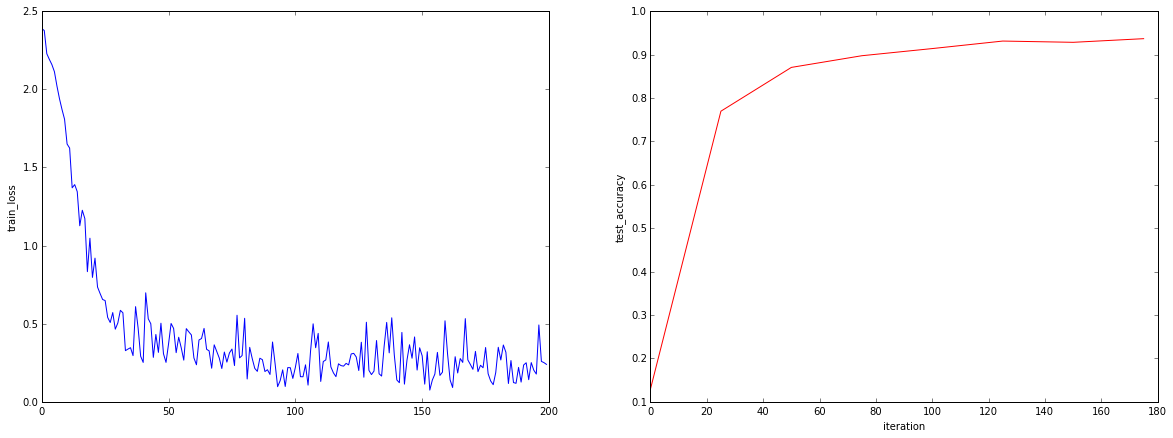

In [4]:
# plot train loss and testset accuracy
rcParams['figure.figsize'] = (20, 7)
pl1 = subplot(1,2,1)
pl1.plot(arange(niter), train_loss)
pl1.set_ylabel('train_loss')
pl2 = subplot(1,2,2)
pl2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
pl2.set_ylabel('test_accuracy')
pl2.set_xlabel('iteration')
# 
print "final accuracy : %.3f" % test_acc[-1]

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
final accuracy : 0.098


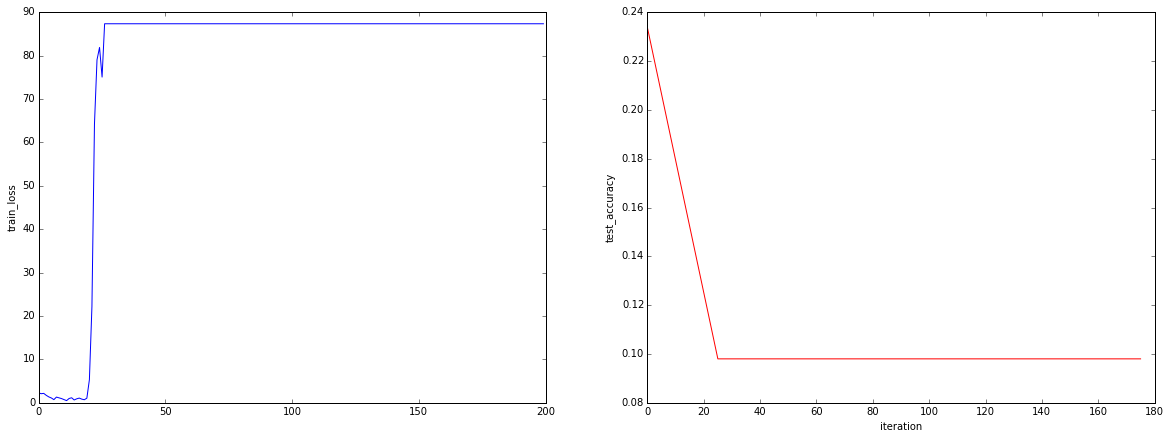

In [5]:
# redo training with learning rate of 0.1

# set up new solver
del solver
solver = caffe.SGDSolver('./models/lenet_solver_lr0.1.prototxt')

niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

# plot train loss and testset accuracy
rcParams['figure.figsize'] = (20, 7)
pl1 = subplot(1,2,1)
pl1.plot(arange(niter), train_loss)
pl1.set_ylabel('train_loss')
pl2 = subplot(1,2,2)
pl2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
pl2.set_ylabel('test_accuracy')
pl2.set_xlabel('iteration')
# 
print "final accuracy : %.3f" % test_acc[-1]

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
final accuracy : 0.848


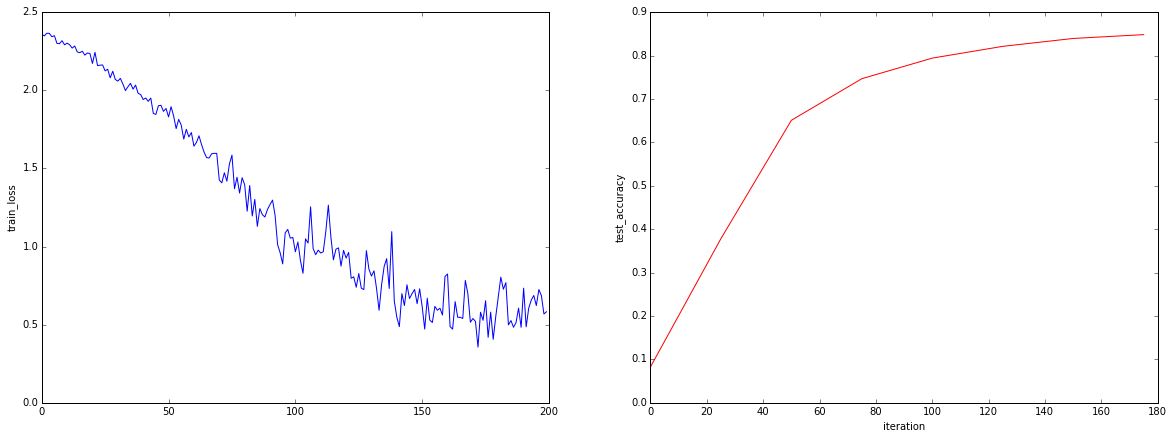

In [6]:
# redo training with learning rate of 0.001

# set up the solver
del solver
solver = caffe.SGDSolver('./models/lenet_solver_lr0.001.prototxt')

niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

# plot train loss and testset accuracy
rcParams['figure.figsize'] = (20, 7)
pl1 = subplot(1,2,1)
pl1.plot(arange(niter), train_loss)
pl1.set_ylabel('train_loss')
pl2 = subplot(1,2,2)
pl2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
pl2.set_ylabel('test_accuracy')
pl2.set_xlabel('iteration')
# 
print "final accuracy : %.3f" % test_acc[-1]